# Initial analysis of the aggregate behaviour

## Instructions
This notebook focuses on creating simple machine learning models which can predict the aggregate behavior of the users for specific tariff signals.

If running this notebook for first time,  start running the cells from [this section](#Initial_setup). Otherwise skip to [This Step](#Read_CSV) which runs CSV file with aggregate meter readings

1. Aggregate dynamic tariff response
    - [Only tariff data](#ML-model-without-any-contextual-variables)
    - [With calendar events](#With-contextual-Variables) 

2. [XGBoost Regressor](#XGBoost-regressor)

In [ ]:
# Load the required packages
import time
import psutil
import numpy as np
import pandas as pd
import glob
import multiprocessing as mp

# For data visualizatoin
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
from bokeh.io import output_notebook, show
from bokeh.models import Title
from bokeh.plotting import figure, output_file, show

from datetime import datetime, timedelta

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import xgboost as xgb


## Initial_setup 
### Only run following steps if you are running the notebook for the first time on the computer
For instructions, [click here](#Instructions)


In [28]:
path=r'../UKDA-7857-csv/csv/data_collection/data_tables'
files_= glob.glob(path+"/*.csv")
print(files_[1])

../UKDA-7857-csv/csv/data_collection/data_tables/survey_answers.csv


In [29]:
df_consumption_d = pd.read_csv(files_[4], sep=',', header=0, index_col=0, parse_dates=['GMT'], low_memory=False)
df_consumption_n = pd.read_csv(files_[0], sep=',', header=0, index_col=0, parse_dates=['GMT'], low_memory=False)
df_tariff = pd.read_csv(files_[2], sep=',', header=0, index_col=0, parse_dates=['GMT'], low_memory=False)

In [ ]:
df_questions = pd.read_csv(files_[3], sep=',', header=0, index_col=0, low_memory=False)
df_answers = pd.read_csv(files_[1], sep=',', header=0, index_col=0, low_memory=False )

In [31]:
# Select only the data during the trials 
df_trial_d = df_consumption_d.loc['2013-01':'2013-12',:]
df_trial_n = df_consumption_n#.loc['2013-01':'2013-12',:]


df_aggregate=pd.DataFrame()
df_aggregate['GMT'] = df_trial_n.index
df_aggregate=df_aggregate.set_index('GMT')

# Take aggregate of the dynamic tariff users
# df_aggregate['trial_d']=df_trial_d.mean(axis=1)

# Take aggregate of the normal tariff users
df_aggregate['trial_n']=df_trial_n.mean(axis=1)

# Add tariff details
# df_aggregate['tariff']=df_tariff.loc['2013-01':'2013-12','Price']


In [ ]:
output_notebook()
# output_file("./temp/line.html") #Uncomment it to save the plot in html file
p=figure(x_axis_type = 'datetime',plot_width=800, plot_height=400)
p.line(df_aggregate.index, df_aggregate.loc[:,"trial_n"].values, line_width=1)
show(p)


In [ ]:
# Saving the above dataframe as CSV file
df_aggregate.to_csv('./mod_datasets/aggregate_consumption.csv', sep=',')

## Read_CSV
This section reads the modified CSV for next steps

[Back to top](#Instructions)

In [5]:
df_aggregate=pd.read_csv('../mod_datasets/aggregate_consumption.csv', sep=',', header=0, index_col=0, parse_dates=['GMT'], low_memory=False)
df_aggregate = df_aggregate.drop_duplicates()
df_midas=pd.read_csv('../mod_datasets/midas_weather.csv', sep=',', header=0, index_col=0, parse_dates=['GMT'], low_memory=False)
df_midas_rs = df_midas.resample('30T').mean()
df_interpolated = df_midas_rs.interpolate(method='linear')
df_weather = df_interpolated.loc['2013-01':'2013-12',:]
# df_interpolated

### Tariff histogram (not important)

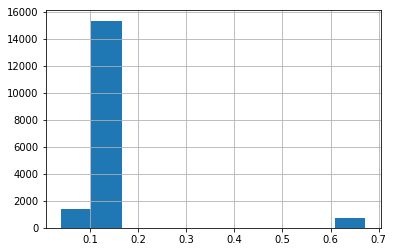

In [6]:
df_aggregate['tariff'].hist()
# df_weather['AIR_TEMPERATURE'].hist()

### Plot aggregate consumption (not important)

In [ ]:
# Plot the usage pattern during the trial
output_notebook()
# output_file("./temp/line.html") #Uncomment it to save the plot in html file
p=figure(x_axis_type = 'datetime',plot_width=800, plot_height=400)
p.line(df_aggregate.index, df_aggregate.loc[:,"trial_d"], line_width=1)
p.line(df_aggregate.index, df_aggregate.loc[:,"trial_n"], line_width=1, color='red')

show(p)


In [8]:
# Making plotting the timeseries easy with following functions

def bokeh_plot1(df1):
    # Plot the usage pattern during the trial
    output_notebook()
#     output_file("./temp/line.html") #Uncomment it to save the plot in html file
    p=figure(x_axis_type = 'datetime',plot_width=800, plot_height=400)
    p.line(df1.index, df1.values, line_width=1, color='blue')
    show(p)
    
def bokeh_plot2(df1,df2):
    # Plot the usage pattern during the trial
    output_notebook()
#     output_file("./temp/line.html") #Uncomment it to save the plot in html file
    p=figure(x_axis_type = 'datetime',plot_width=800, plot_height=400)
    p.line(df1.index, df1.values, line_width=1, color='blue')
    p.line(df2.index, df2.values, line_width=1, color='red')
    show(p)
    
def bokeh_plot3(df1,df2,df3):
    # Plot the usage pattern during the trial
    output_notebook()
#     output_file("./temp/line.html") #Uncomment it to save the plot in html file
    p=figure(x_axis_type = 'datetime',plot_width=800, plot_height=400)
    p.line(df1.index, df1.values, line_width=1, color='blue')
    p.line(df2.index, df2.values, line_width=1, color='red')
    p.line(df3.index, df3.values, line_width=1, color='green')
    show(p)

In [9]:
# DIFFERENCING Function: Removing the trends and non-stationarity

def make_stationary(df):
    df_ = df.copy()
    # Now shift the timeseries by one day: 48
    df_1w = df_.tshift(-48)
    # Take a moving average of last week
    df_1w_ma = df_1w.rolling(48*7).mean().copy()
    # Calculate the difference of last week's mean and current value
    df_diff = (df_ - df_1w_ma).copy()
    
    return df_diff, df_1w_ma


## ML model without any contextual variables

In [ ]:
# Differencing the data 
df_stationary, df_1w_ma = make_stationary(df_aggregate[['trial_d', 'trial_n']])

## Ploting the differenced 
bokeh_plot3(df_stationary['trial_d'], df_aggregate['trial_d'], df_1w_ma['trial_d'])

# Dropping the NaN created due to differencing operation
df_stationary['tariff'] = df_aggregate['tariff']
df_dropna = df_stationary.dropna().copy()

# Add one-hot-encodings
one_hot= pd.get_dummies(df_dropna['tariff'])

# Renaming the one-hot-encode dataframe columns
one_hot_renamed = one_hot.rename(index=str, columns={0.0399:'low', 0.1176:'normal', 0.672:'high'}) 
df_all = df_dropna.join(one_hot_renamed).drop('tariff', axis=1)

In [11]:
# Setting up the dependent and independent variables for above dataframe
X_variables = ['trial_n', 'low', 'normal','high']
y_variable = ['trial_d']

## With contextual Variables

In [12]:
df_context = pd.concat([df_aggregate,df_weather], axis=1)

tariff_temp = df_context['tariff']
df_for_diff = df_context.drop(['tariff'], axis=1)

df_stationary, df_1w_ma = make_stationary(df_context)

# # Dropping the NaN created due to differencing operation
# df_stationary['tariff'] = tariff_temp.astype('str')
# df_all = df_stationary.dropna().copy()



df_stationary['tariff'] = tariff_temp
df_dropna = df_stationary.dropna().copy()

# Add one-hot-encodings
one_hot= pd.get_dummies(df_dropna['tariff'])

# Renaming the one-hot-encode dataframe columns
one_hot_renamed = one_hot.rename(index=str, columns={0.0399:'low', 0.1176:'normal', 0.672:'high'}) 
df_all = df_dropna.join(one_hot_renamed).drop('tariff', axis=1)


In [13]:
# Setting up the dependent and independent variables for above dataframe
cols = list(df_all.columns.values)
cols_remove = ['trial_d', 'tariff'] #Add/Remove the variables to add/remove them from feature list

X_variables = [i for i in cols if i not in cols_remove]
y_variable = ['trial_d']

### Creating training and testing sets


In [14]:
# seed = 7
# test_size = 0.2
# X_train, X_test, y_train, y_test = train_test_split(df_all[['trial_n', 'low', 'normal','high']], df_all['trial_d'], test_size=test_size, random_state=seed)

X_train1 = df_all.loc['2013-01':'2013-09',X_variables]
y_train1 = df_all.loc['2013-01':'2013-09',y_variable]
X_test1 = df_all.loc['2013-10':,X_variables]
y_test1 = df_all.loc['2013-10':,y_variable]

### Performance Measures

In [15]:
def performance_check(y_test1, preds1):
    rmse = sqrt(mean_squared_error(y_test1, preds1))/np.mean(y_test1)
    mae = mean_absolute_error(y_test1, preds1)/np.mean(y_test1)
    print('The Normalized RMSE is: ', rmse)
    print('The Normalized MAE is: ', mae)


### XGBoost regressor

In [26]:
def xgb_regressor(X_train, y_train, X_test, y_test):
    xg_reg = xgb.XGBRegressor(n_estimators=50)
    xg_reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
            verbose=False) # Change verbose to True if you want to see it train
    
    # Get feature importance chart
    xgb.plot_importance(xg_reg, height=0.9) # Plot feature importance
    
    # Get the predictions
    preds = xg_reg.predict(X_test)
    
    # Get performance measure (RMSE)
    performance_check(y_test, preds)
    
    # Plot the predictions
    output_notebook()
    p=figure(x_axis_type = 'datetime',plot_width=800, plot_height=400, title = "Demand response for dToU (November)")
    p.line(X_train.index, X_train.loc[:,"trial_n"], line_width=1, color='gray')
    p.line(X_test.index, X_train.loc[:,"trial_n"], line_width=1, color='gray')
    p.line(X_train.index, y_train.loc[:,"trial_d"], line_width=1, color='blue')
    p.line(X_test.index, y_test.loc[:,"trial_d"], line_width=1, color='blue')

    show(p)
    
    return preds

    
    

The Normalized RMSE is:  trial_d    5.222098
dtype: float64
The Normalized MAE is:  trial_d    3.966073
dtype: float64


Loading BokehJS ...

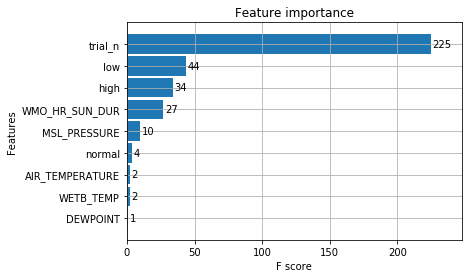

In [27]:
y_preds = xgb_regressor(X_train1, y_train1, X_test1, y_test1)